In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from scipy import optimize
from astroML.resample import bootstrap
from scipy.special import erfinv
import matplotlib as mpl
import seaborn as sns
from astroML.plotting import plot_mcmc
import emcee
#from matplotlib.animation import FuncAnimation
#import matplotlib.animation as animation
from celluloid import Camera
mpl.style.use('../sample.mplstyle')
np.random.seed(1)

# Frequentists vs. Bayesians
This notebook is meant to highlight some examples where frequentists and Bayesians would get similar or different results. These examples all are taken (and only modified slightly) from Jake VanderPlas' [paper on the topic](https://arxiv.org/pdf/1411.5018.pdf) as well as his corresponding [set of notebooks](http://jakevdp.github.io/blog/2014/06/06/frequentism-and-bayesianism-2-when-results-differ/).

To start, I will assume you are familiar with all of the equations defined in Carlos Arguelles' [Statistics for little penguins](https://events.icecube.wisc.edu/event/99/contributions/5946/attachments/5020/5528/doc01.pdf) document, but will try to include Equations throughout

## Example 1: Neutrino Counts

### The problem:
Imagine you have a very strong neutrino source (a problem we wish we had), and we want to estimate its intrinsic flux, $F_{true}$. We will assume this is constant over time, and will concern ourselves only with counts, not fluxes (ie counts per energy per area per time). We perform $N$ measurements, where for each measurement, $i$, we count the number of observed neutrinos $F_i$ (we will assume the error on each of these is poissonian, ie $\sigma_i = \sqrt F_i$).

The question is, given our set of measurements, $D = \{F_i, e_i\}$, what is our best estimate of the flux, $F_{true}$?

First, we take our measurements:

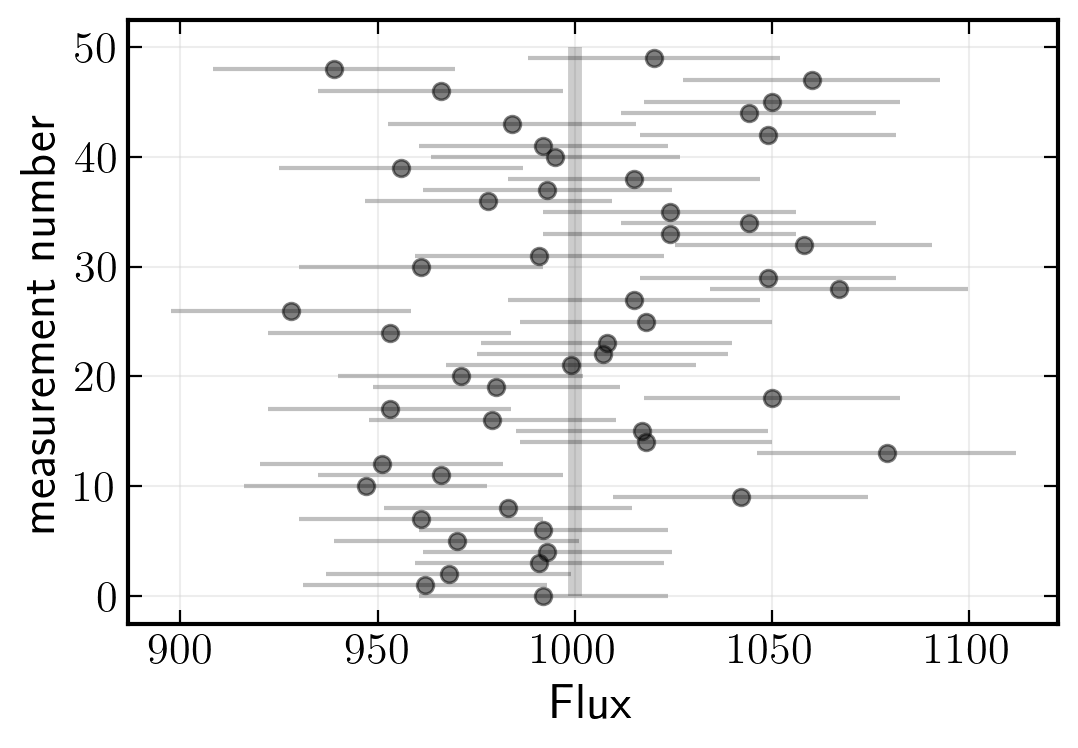

In [14]:
F_true = 1000  # true flux, say number of neutrinos measured in each period
N = 50 # number of measurements
F = np.random.poisson(F_true, size=N)  # N measurements
e = np.sqrt(F)  # errors

fig, ax = plt.subplots()
ax.errorbar(F, np.arange(N), xerr=e, fmt='ok', ecolor='gray', alpha=0.5)
ax.vlines([F_true], 0, N, linewidth=5, alpha=0.2)
ax.set_xlabel("Flux"); ax.set_ylabel("measurement number");

#### Frequentist approach:
To be a frequentist, we start with the likelihood, 
$$\mathcal{L}\left(D | F_{\text {true }}\right)=\prod_{i=1}^{N} P\left(D_{i} | F_{\text {true }}\right)$$
where 
$$ P\left(D_{i} | F_{\mathrm{true}}\right)=\frac{1}{\sqrt{2 \pi e_{i}^{2}}} \exp \left[\frac{-\left(F_{i}-F_{\mathrm{true}}\right)^{2}}{2 e_{i}^{2}}\right]\;.$$
We want to _maximize_ this likelihood, and if we are just looking for the parameter values which accomplish this, it is equivalent to maximizing the log of this likelihood, 
$$\log \mathcal{L}=-\frac{1}{2} \sum_{i=1}^{N}\left[\log \left(2 \pi e_{i}^{2}\right)+\frac{\left(F_{i}-F_{\text {true }}\right)^{2}}{e_{i}^{2}}\right]\;.$$
Next, we extremize
$$\frac{d\log \mathcal{L}}{dF_{true}}|_{\hat{F}_{true}} = 0$$
$$\rightarrow \sum\frac{F_i}{e_i^2} = N \hat{F}_{true} \sum\frac{1}{e_i^2}$$
$$\rightarrow \hat{F}_{true} = \frac{1}{N}\frac{\sum_{i=1}^N F_i / e_i^2}{\sum_{i=1}^N 1/e_i^2}\;,$$
which in the limit of equal errors is just the average, likely as you expected. If you are interested in the error of our estimate, it can be shown that this is equal to
$$\sigma_{\mathrm{est}}=\left(\sum_{i=1}^{N} 1/e_{i}^2\right)^{-1 / 2} $$

For our measurements, this gives us:

In [4]:
w = 1. / e ** 2
F_est = (w * F).sum() / w.sum()
F_est_err = w.sum() ** -0.5
print(f"F_true = {F_true}\nF_est  = {F_est:.0f} +/- {F_est_err:.0f} "
      + f"(based on {N} measurements)")

F_true = 1000
F_est  = 998 +/- 4 (based on 50 measurements)


### Bayesian approach:
In our Bayesian approach, we would like to find the maximum a posteriori of out posterior distribution, $P\left(F_{\text {true }} | D\right)$. To find this, we start with (no surprise here) Bayes' Theorem:
$$P\left(F_{\text {true }} | D\right)=\frac{P\left(D | F_{\text {true }}\right) P\left(F_{\text {true }}\right)}{P(D)}\; .$$

Breaking these terms on the right down one-by-one, we have:
* $P\left(D | F_{\text {true }}\right)$: the likelihood (proportional to the one in the frequentist approach)
* $P\left(F_{\text {true }}\right)$: the prior (encodes what we know prior to our acquiring the data, $D$)
* $P(D)$: the data probability (just a normalization, so we'll ignore that)

If we use a flat prior, then we find that we have our posterior 
$$P\left(F_{\text {true }} | D\right) \propto \mathcal{L}\left(D | F_{\text {true }}\right)$$

WAIT, what gives? That's gonna give us the same thing as the frequentist approach. While this might be true, it highlights the fact that people often think Bayesians and frequentists are answering the same question with the same tools, because with some simple examples, they give the same results. Later examples will show that this is _not the case_.

Before getting to that, it's not always the case that we can do everything analytically. There are a lot of tools to help you calculate posterior distributions based off of sampling algorithms like [Markov Chain Monte Carlos](http://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo). I won't go into the theory here, but I will show you how to use them. All you need is a numerical way to calculate your prior and your likelihood (see next cell)

In [16]:
def log_prior(theta): 
    return 1  # flat prior, 
              #feel free to change this and see 
              #how your results move around

def log_likelihood(theta, F, e): 
    return -0.5 * np.sum(np.log(2 * np.pi * e ** 2)
                         + (F - theta[0]) ** 2 / e ** 2)

def log_posterior(theta, F, e):
    return log_prior(theta) + log_likelihood(theta, F, e)

F_true = 1000
F_est  = 998 +/- 4 (based on 50 measurements)


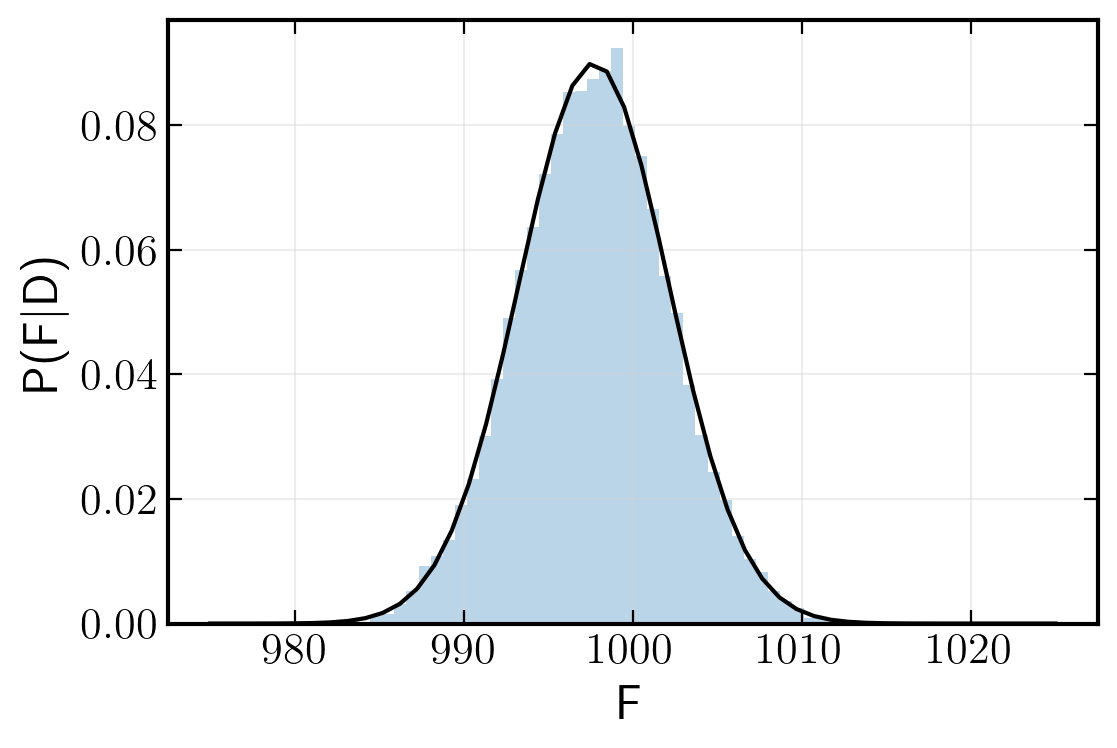

In [23]:
ndim = 1  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 2000  # number of MCMC steps to take

# we'll start at random locations between 0 and 2000
starting_guesses = 2000 * np.random.rand(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[F, e])
sampler.run_mcmc(starting_guesses, nsteps)

sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].ravel()  # discard burn-in points

plt.hist(sample, bins=50, histtype="stepfilled", alpha=0.3, density=True)

# plot a best-fit Gaussian
F_fit = np.linspace(975, 1025)
pdf = stats.norm(np.mean(sample), np.std(sample)).pdf(F_fit)

plt.plot(F_fit, pdf, '-k')
plt.xlabel("F"); plt.ylabel(r'P(F$|$D)')

F_est = np.mean(sample); F_est_err = np.std(sample)
print(f"F_true = {F_true}\nF_est  = {F_est:.0f} +/- {F_est_err:.0f} (based on {N} measurements)")

## Example 1b: Neutrino Counts (with 2 dimensions)
This example didn't make it to the slides, but you could also consider an example with a source whose underlying flux varies, for example, one in which the flux at a given observation time is now given by 
$$F_{\text {true }} \sim \frac{1}{\sqrt{2 \pi \sigma^{2}}} \exp \left[\frac{-(F-\mu)^{2}}{2 \sigma^{2}}\right]$$

### Frequentist approach:
We have the likelihood, 
$$\mathcal{L}(D | \theta)=\prod_{i=1}^{N} \frac{1}{\sqrt{2 \pi\left(\sigma^{2}+e_{i}^{2}\right)}} \exp \left[\frac{-\left(F_{i}-\mu\right)^{2}}{2\left(\sigma^{2}+e_{i}^{2}\right)}\right]\; ,$$
but now, if we extremize, we find that the optimal value of $\mu$ depends on the optimal value of $\sigma$, 
$$\mu_{e s t}=\frac{\sum w_{i} F_{i}}{\sum w_{i}} ; \quad w_{i}=\frac{1}{\sigma^{2}+e_{i}^{2}}\; .$$
Instead of doing the extremization by hand, we can turn to numerical techniques, as seen below

In [30]:
np.random.seed(42)  # for reproducibility
N = 100  # we'll use more samples for the more complicated model
mu_true, sigma_true = 1000, 15  # stochastic flux model

F_true = stats.norm(mu_true, sigma_true).rvs(N)  # (unknown) true flux
F = stats.poisson(F_true).rvs()  # observed flux: true flux plus Poisson errors.
e = np.sqrt(F)  # root-N error, as above

def log_likelihood(theta, F, e):
    return -0.5 * np.sum(np.log(2 * np.pi * (theta[1] ** 2 + e ** 2))
                         + (F - theta[0]) ** 2 / (theta[1] ** 2 + e ** 2))

# maximize likelihood <--> minimize negative likelihood
def neg_log_likelihood(theta, F, e):
    return -log_likelihood(theta, F, e)

theta_guess = [900, 5]
theta_est = optimize.fmin(neg_log_likelihood, theta_guess, args=(F, e))
print("""
      Maximum likelihood estimate for {0} data points:
          mu={theta[0]:.0f}, sigma={theta[1]:.0f}
      """.format(N, theta=theta_est))

Optimization terminated successfully.
         Current function value: 502.839505
         Iterations: 58
         Function evaluations: 114

      Maximum likelihood estimate for 100 data points:
          mu=999, sigma=19
      


Calculating the error on these estimators is in itself a can of worms. Some techniques rely on fitting the likelihood space and reporting the covariance matrix. The technique used below is a [sampling approach](http://en.wikipedia.org/wiki/Bootstrapping_(statistics)), which maximize the likelihood for randomized subsets of the input data to explore the degree of certainty of the results

In [31]:
def fit_samples(sample):
    # sample is an array of size [n_bootstraps, n_samples]
    # compute the maximum likelihood for each bootstrap.
    return np.array([optimize.fmin(neg_log_likelihood, theta_guess,
                                   args=(F, np.sqrt(F)), disp=0)
                     for F in sample])

samples = bootstrap(F, 1000, fit_samples)  # 1000 bootstrap resamplings

mu_samp = samples[:, 0]
sig_samp = abs(samples[:, 1])

print(" mu    = {0:.0f} +/- {1:.0f}".format(mu_samp.mean(), mu_samp.std()))
print(" sigma = {0:.0f} +/- {1:.0f}".format(sig_samp.mean(), sig_samp.std()))

 mu    = 999 +/- 4
 sigma = 18 +/- 5


### Bayesian Approach:

While the frequentist approach got a lot more complicated with calculating errors and such, the bayesian approach actually scales quite nicely.

Instead of showing the posterior in one dimension, we show the samples in two dimensions, with 68% and 95% confidence levels

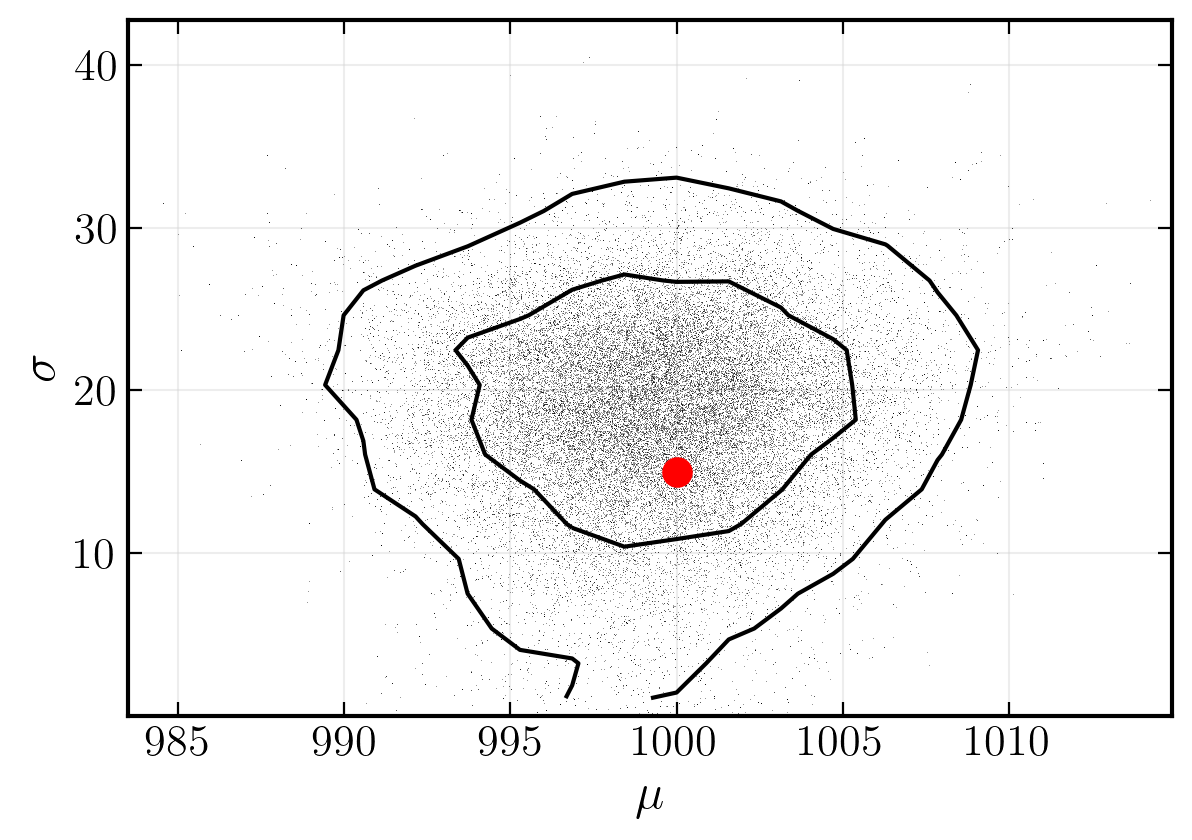

In [32]:
def log_prior(theta):
    # sigma needs to be positive.
    if theta[1] <= 0:
        return -np.inf
    else:
        return 0

def log_posterior(theta, F, e):
    return log_prior(theta) + log_likelihood(theta, F, e)

# same setup as above:
ndim, nwalkers = 2, 50
nsteps, nburn = 2000, 1000

starting_guesses = np.random.rand(nwalkers, ndim)
starting_guesses[:, 0] *= 2000  # start mu between 0 and 2000
starting_guesses[:, 1] *= 20    # start sigma between 0 and 20

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[F, e])
sampler.run_mcmc(starting_guesses, nsteps)

sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].reshape(-1, 2)

fig = plt.figure()
ax = plot_mcmc(sample.T, fig=fig, labels=[r'$\mu$', r'$\sigma$'], colors='k')
ax[0].plot(sample[:, 0], sample[:, 1], ',k', alpha=0.4)
ax[0].plot([mu_true], [sigma_true], 'o', color='red', ms=10);

## Example 2: The Bayesian Billiard game (nuisance parameters)

For more complicated examples, frequentist and bayesian results will differ. This is often the case when there are nuisance paramters, or quantities whose value is not relevant to the foal of the analysis, but is nevertheless required to determine some quantity of interest

*The problem*: Alice and Bob enter a room. Behind a curtain there is a billiard table, which they cannot see, but their friend Carol can. Carol rolls a ball down the table, and marks where it lands. Once this mark is in place, Carol begins rolling new balls down the table. If the ball lands to the left of the mark, Alice gets a point; if it lands to the right of the mark, Bob gets a point. We can assume for the sake of example that Carol's rolls are unbiased: that is, the balls have an equal chance of ending up anywhere on the table. The first person to reach six points wins the game.

Here the location of the mark (determined by the first roll) can be considered a nuisance parameter: it is unknown, and not of immediate interest, but it clearly must be accounted for when predicting the outcome of subsequent rolls. If the first roll settles far to the right, then subsequent rolls will favor Alice. If it settles far to the left, Bob will be favored instead.

*The question*: In a particular game, after eight rolls, Alice has five points and Bob has three points. What is the probability that Bob will go on to win the game?

### A Frequentist Approach:
Our likelihood here is just a binomial likelihood. It can easily be shown that if we want to estimate the probability, $p$, that any given roll lands on Alice's size, then our best guess is just 
$$\hat{p} = 5/8 $$
I'll leave the proof to the reader. Then, the probability of Bob winning is given by 
$$ P(Bob) = (1 - \hat{p})^3 $$

In [39]:
p_bob = (1. - (5./8.))**3.
p_alice = 1.-p_bob
ratio = p_alice / p_bob
print(f"Alice is {ratio:.0f} times more likely to win than Bob")

Alice is 18 times more likely to win than Bob


### A Bayesian Approach
The general Bayesian method of treating nuisance parameters is *marginalization*, or integrating the joint probability over the entire range of the nuisance parameter. In this case, that means that we will first calculate the joint distribution
$$
P(B,p~|~D)
$$
and then marginalize over $p$ using the following identity:
$$
P(B~|~D) \equiv \int_{-\infty}^\infty P(B,p~|~D) {\mathrm d}p
$$
This identity follows from the definition of conditional probability, and the law of total probability: that is, it is a fundamental consequence of probability axioms and will always be true. Even a frequentist would recognize this; they would simply disagree with our interpretation of $P(p)$ as being a measure of uncertainty of our own knowledge.

We'll start by applying the following definition of [conditional probability](http://en.wikipedia.org/wiki/Conditional_probability#Definition) to expand the term $P(B,p~|~D)$:

$$
P(B~|~D) = \int P(B~|~p, D) P(p~|~D) dp
$$

Next we use [Bayes' rule](http://en.wikipedia.org/wiki/Bayes%27_theorem) to rewrite $P(p~|~D)$:

$$
P(B~|~D) = \int P(B~|~p, D) \frac{P(D~|~p)P(p)}{P(D)} dp
$$

Finally, using the same probability identity we started with, we can expand $P(D)$ in the denominator to find:

$$
P(B~|~D) = \frac{\int P(B~|~p,D) P(D~|~p) P(p) dp}{\int P(D~|~p)P(p) dp}
$$

Now the desired probability is expressed in terms of three quantities that we can compute. Let's look at each of these in turn:

- $P(B~|~p,D)$: This term is exactly the frequentist likelihood we used above. In words: given a marker placement $p$ and the fact that Alice has won 5 times and Bob 3 times, what is the probability that Bob will go on to six wins?  Bob needs three wins in a row, i.e. $P(B~|~p,D) = (1 - p) ^ 3$.
- $P(D~|~p)$: this is another easy-to-compute term. In words: given a probability $p$, what is the likelihood of exactly 5 positive outcomes out of eight trials? The answer comes from the well-known [Binomial distribution](http://en.wikipedia.org/wiki/Binomial_distribution): in this case $P(D~|~p) \propto p^5 (1-p)^3$
- $P(p)$: this is our prior on the probability $p$. By the problem definition, we can assume that $p$ is evenly drawn between 0 and 1.  That is, $P(p) \propto 1$, and the integrals range from 0 to 1.

Putting this all together, canceling some terms, and simplifying a bit, we find
$$
P(B~|~D) = \frac{\int_0^1 (1 - p)^6 p^5 dp}{\int_0^1 (1 - p)^3 p^5 dp}
$$
where both integrals are evaluated from 0 to 1.

These integrals might look a bit difficult, until we notice that they are special cases of the [Beta Function](http://en.wikipedia.org/wiki/Beta_function):
$$
\beta(n, m) = \int_0^1 (1 - p)^{n - 1} p^{m - 1}
$$
The Beta function can be further expressed in terms of gamma functions (i.e. factorials), but for simplicity we'll compute them directly using Scipy's beta function implementation:

In [5]:
from scipy.special import beta
bayes_prob = beta(6 + 1, 5 + 1) / beta(3 + 1, 5 + 1)

print("P(B|D) = {0:.2f}".format(bayes_prob))
print("Bayesian odds against Bob winning: {0:.0f} to 1".format((1. - bayes_prob) / bayes_prob))

P(B|D) = 0.09
Bayesian odds against Bob winning: 10 to 1


### So, who is right?

In [7]:
# play 100000 games with randomly-drawn p, between 0 and 1
p = np.random.random(100000)

# each game needs at most 11 rolls for one player to reach 6 wins
rolls = np.random.random((11, len(p)))

# count the cumulative wins for Alice and Bob at each roll
Alice_count = np.cumsum(rolls < p, 0)
Bob_count = np.cumsum(rolls >= p, 0)

In [8]:
# sanity check: total number of wins should equal number of rolls
total_wins = Alice_count + Bob_count
assert np.all(total_wins.T == np.arange(1, 12))
print("(Sanity check passed)")

(Sanity check passed)


In [9]:
# determine number of games which meet our criterion of 
#(A wins, B wins)=(5, 3)
# this means Bob's win count at eight rolls must equal 3
good_games = Bob_count[7] == 3
print("Number of suitable games: {0}".format(good_games.sum()))

Number of suitable games: 11018


In [10]:
# truncate our results to consider only these games
Alice_count = Alice_count[:, good_games]
Bob_count = Bob_count[:, good_games]

# determine which of these games Bob won.
# to win, he must reach six wins after 11 rolls.
bob_won = np.sum(Bob_count[10] == 6)
print("Number of these games Bob won: {0}".format(bob_won.sum()))

Number of these games Bob won: 973


In [12]:
# compute the probability
mc_prob = bob_won.sum() * 1. / good_games.sum()
print("Monte Carlo Probability of Bob winning: {0:.2f}".format(mc_prob))
print("MC Odds against Bob winning: {0:.0f} to 1".format(
    (1. - mc_prob) / mc_prob))

Monte Carlo Probability of Bob winning: 0.09
MC Odds against Bob winning: 10 to 1


## Example 4: Jaynes' Truncated Exponential (confidence vs. creditbility)

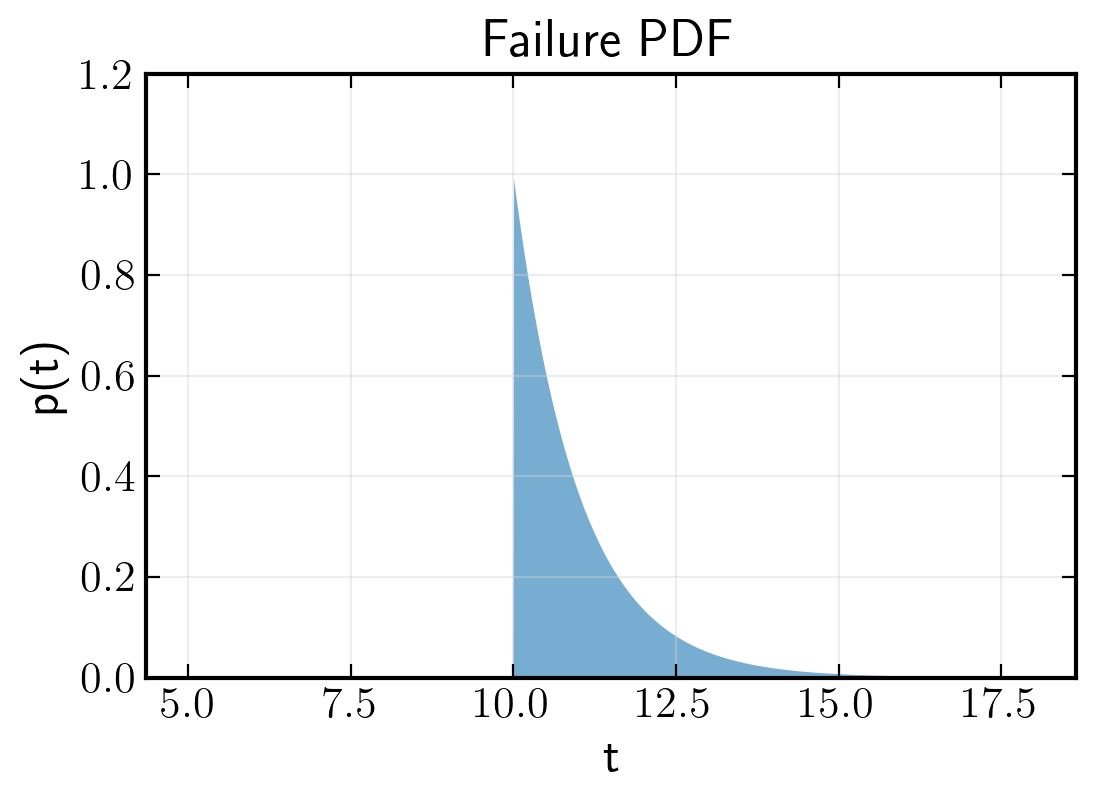

In [4]:
def p(x, theta):
    return (x > theta) * np.exp(theta - x)

x = np.linspace(5, 18, 1000)
plt.fill(x, p(x, 10), alpha=0.6)
plt.ylim(0, 1.2)
plt.xlabel('t'); plt.ylabel('p(t)');
plt.title('Failure PDF')
plt.show()

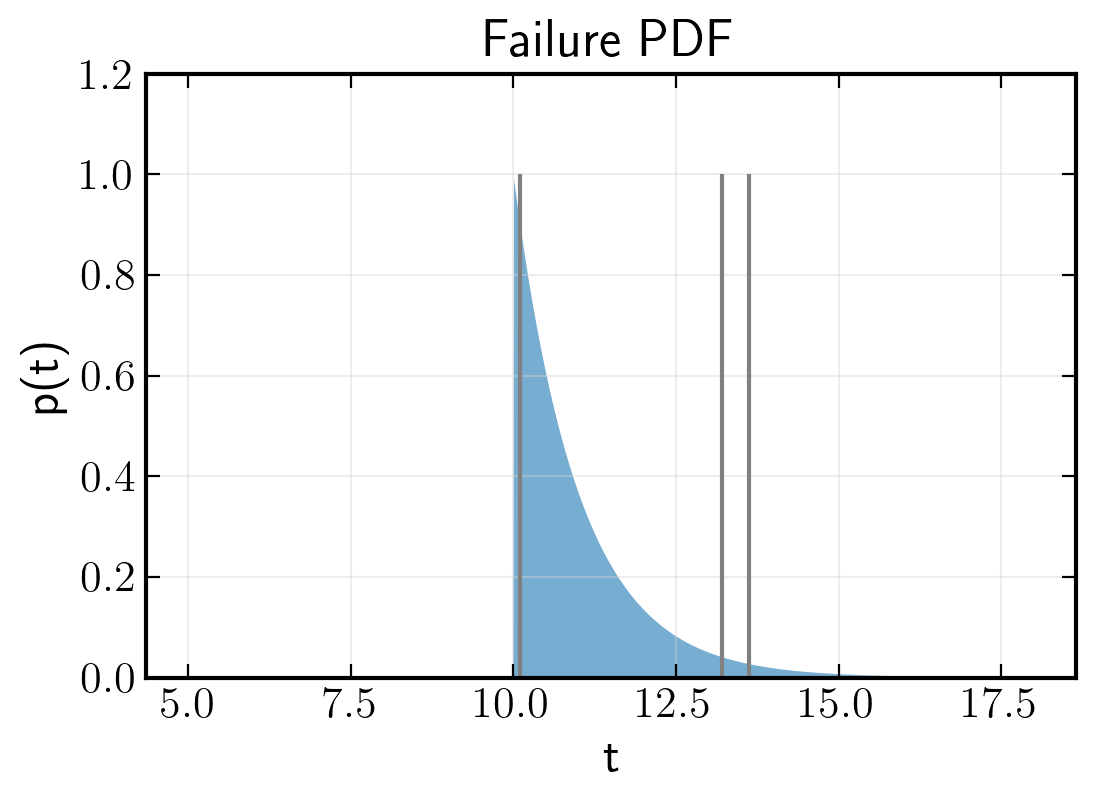

In [5]:
plt.fill(x, p(x, 10), alpha=0.6)
plt.ylim(0, 1.2)
plt.xlabel('t'); plt.ylabel('p(t)'); plt.title('Failure PDF');
np.random.seed(546)
D = np.random.exponential(size=3) + 10.
plt.vlines(D, ymin=0, ymax=1., color = 'grey')
plt.show()

### Frequentist approach:

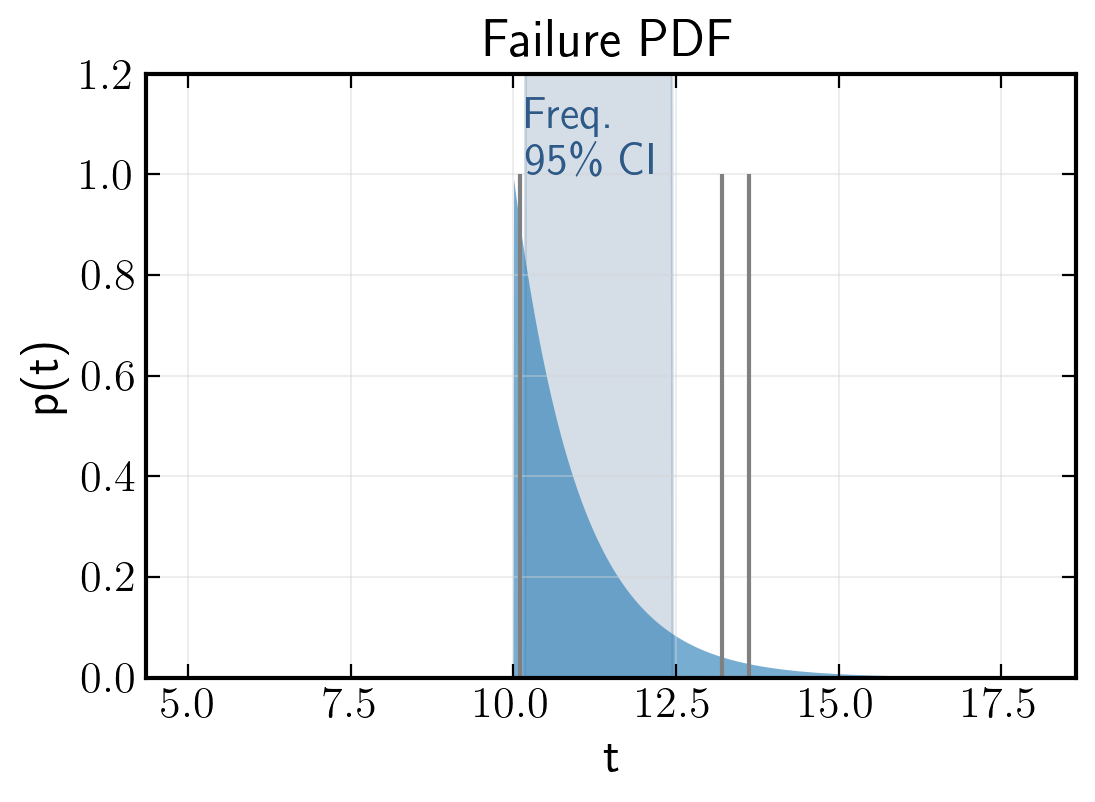

frequentist:          95% CI = (10.2, 12.4)


In [6]:
def approx_CI(D, sig=0.95):
    """Approximate truncated exponential confidence interval"""
    # use erfinv to convert percentage to number of sigma
    Nsigma = np.sqrt(2) * erfinv(sig)
    D = np.asarray(D)
    N = D.size
    theta_hat = np.mean(D) - 1
    return [theta_hat - Nsigma / np.sqrt(N),
            theta_hat + Nsigma / np.sqrt(N)]

freq_lims = approx_CI(D)
freq_band = (x>freq_lims[0]) * (x < freq_lims[1]) * 1.2

plt.fill(x, p(x, 10), alpha=0.6)
plt.ylim(0, 1.2)
plt.xlabel('t'); plt.ylabel('p(t)'); plt.title('Failure PDF');
np.random.seed(546)
D = np.random.exponential(size=3) + 10.
plt.vlines(D, ymin=0, ymax=1., color = 'grey')
plt.fill_between(x, freq_band, color = sns.xkcd_rgb['light navy blue'], alpha=0.2)
plt.text(freq_lims[0], 1.0, 'Freq.\n 95\% CI', color = sns.xkcd_rgb['light navy blue'])
plt.show()

print("frequentist:          95% CI = ({0:.1f}, {1:.1f})".format(*approx_CI(D)))

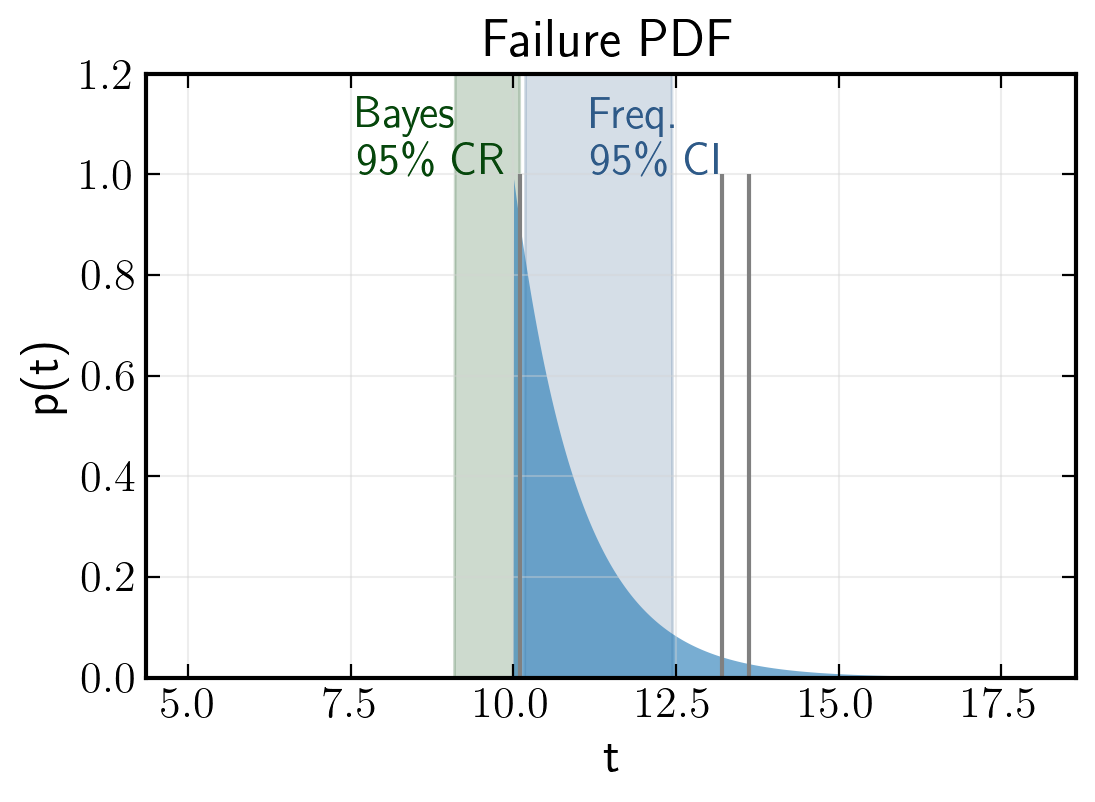

frequentist:          95% CI = (10.2, 12.4)
Bayesian:             95% CR = (9.1, 10.1)


In [7]:
def bayes_CR(D, frac=0.95):
    """Bayesian Credibility Region"""
    D = np.asarray(D)
    N = float(D.size)
    theta2 = D.min()
    theta1 = theta2 + np.log(1. - frac) / N
    return theta1, theta2

bayes_lims = bayes_CR(D)
bayes_band = (x>bayes_lims[0]) * (x < bayes_lims[1]) * 1.2

plt.fill(x, p(x, 10), alpha=0.6)
plt.ylim(0, 1.2)
plt.xlabel('t'); plt.ylabel('p(t)'); plt.title('Failure PDF');
np.random.seed(546)
D = np.random.exponential(size=3) + 10.
plt.vlines(D, ymin=0, ymax=1., color = 'grey')

plt.fill_between(x, freq_band, color = sns.xkcd_rgb['light navy blue'], alpha=0.2)
plt.text(freq_lims[0] + 1, 1.0, 'Freq.\n 95\% CI', color = sns.xkcd_rgb['light navy blue'])

plt.fill_between(x, bayes_band, color = sns.xkcd_rgb['forest green'], alpha=0.2)
plt.text(bayes_lims[0]-1.5, 1.0, 'Bayes\n 95\% CR', color = sns.xkcd_rgb['forest green'])

plt.show()

print("frequentist:          95% CI = ({0:.1f}, {1:.1f})".format(*approx_CI(D)))
print("Bayesian:             95% CR = ({0:.1f}, {1:.1f})".format(*bayes_CR(D)))

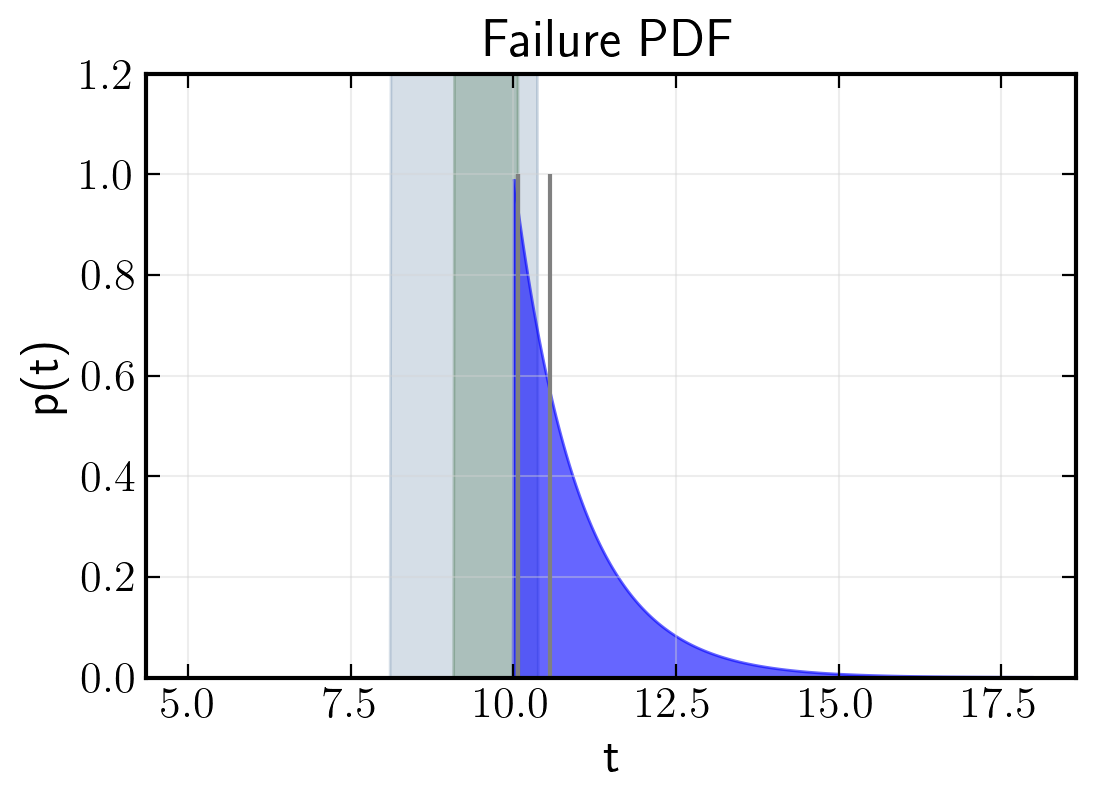

In [10]:
fig = plt.figure()
camera = Camera(fig)

for kk in range(30):
    D = np.random.exponential(size=3) + 10.

    freq_lims = approx_CI(D)
    freq_band = (x>freq_lims[0]) * (x < freq_lims[1]) * 1.2
    bayes_lims = bayes_CR(D)
    bayes_band = (x>bayes_lims[0]) * (x < bayes_lims[1]) * 1.2

    plt.fill(x, p(x, 10), alpha=0.6, color = 'blue')
    plt.ylim(0, 1.2)
    plt.xlabel('t'); plt.ylabel('p(t)'); plt.title('Failure PDF');
    plt.vlines(D, ymin=0, ymax=1., color = 'grey')
    plt.fill_between(x, freq_band, color = sns.xkcd_rgb['light navy blue'], alpha=0.2)
    plt.fill_between(x, bayes_band, color = sns.xkcd_rgb['forest green'], alpha=0.2)
    camera.snap()

animation = camera.animate(blit=True)
animation.save('/home/apizzuto/public_html/animations/frequentist_bayesian.gif', 
               writer = 'imagemagick', fps=1, )
plt.show()